<a href="https://colab.research.google.com/github/saimani5/ferroelectric_domains_rVAE/blob/main/AtomAI_Analysis_of_BiFeO3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by Chris


Mount Google Drive (only needed for saves):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import standard modules:

In [11]:
import os
import numpy as np
import h5py
try:
    import gdown
except ModuleNotFoundError:
    !pip install gdown
    import gdown
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import seaborn as sns
from sklearn import decomposition
from scipy import signal
np.random.seed(1)

Import colormapping tools: colorspacious & papuc

In [12]:
#colorspacious
try:
    import colorspacious
except ModuleNotFoundError:
    !pip install colorspacious
    import colorspacious

!pip install git+https://github.com/ziatdinovmax/atomai@legacy --upgrade  #install legacy version which is sufficient for this notebook

from atomai import utils
from atomai import atomstat
import torch
torch.manual_seed(0)


#papuc
if not os.path.exists('papuc/'):
    !git clone https://github.com/MTD-group/papuc.git
else:
    !git pull https://github.com/MTD-group/papuc.git papuc/.git        
from importlib.machinery import SourceFileLoader
papuc = SourceFileLoader('papuc', 'papuc/papuc/__init__.py').load_module()

fatal: not a git repository (or any of the parent directories): .git


Outputs Save Path

In [13]:
mdirectory = '/content/drive/My Drive/Colab Notebooks/Outputs/rVAE Ferro/'
if not os.path.exists(mdirectory):
    os.makedirs(mdirectory)  

Input Files

In [14]:
#HAADF Image
url = 'https://drive.google.com/uc?id=1Grh6JmAX_t9Ws_kZSachDm7xo8ntm-mE'
imfile = 'HAADF.h5'
gdown.download(url, imfile, quiet=False)

#Parameters
url = 'https://drive.google.com/uc?id=182EFt32zfSOmM68gz08XshIo2o5BNUeC'
parfile = 'atmparams.p'
gdown.download(url, parfile, quiet=False)

url = 'https://drive.google.com/uc?id=1a5pLLwaXWxWivhaj3iGhtBkDevQrIoNd'
imstackparfile = 'imstack_params.p'
gdown.download(url, imstackparfile, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Grh6JmAX_t9Ws_kZSachDm7xo8ntm-mE
To: /content/HAADF.h5
157MB [00:00, 305MB/s]
Downloading...
From: https://drive.google.com/uc?id=182EFt32zfSOmM68gz08XshIo2o5BNUeC
To: /content/atmparams.p
15.0MB [00:00, 203MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a5pLLwaXWxWivhaj3iGhtBkDevQrIoNd
To: /content/imstack_params.p
599MB [00:02, 259MB/s]


'imstack_params.p'

In [15]:
#list files
filedir = '/content'
[f for f in os.listdir(filedir)]

['.config',
 'atmparams.p',
 'papuc',
 'drive',
 'imstack_params.p',
 'HAADF.h5',
 'sample_data']

In [16]:
#extract data
imgdata = h5py.File(os.path.join(filedir, imfile), 'r')['MainImage']
imgscl = h5py.File(os.path.join(filedir, imfile), 'r')['Scale']
imgunit = h5py.File(os.path.join(filedir, imfile), 'r')['Units(m)']
#ap = h5py.File(os.path.join(filedir, parfile), 'r')
ap = np.load(os.path.join(filedir, parfile), allow_pickle=True)
print('atom parameters: '+str(ap.keys()))
imp = np.load(os.path.join(filedir, imstackparfile), allow_pickle=True)
print('image stack parameters: '+str(imp.keys()))

atom parameters: dict_keys(['i', 'type', 'xy', 'nbrind', 'nbrvect', 'nbrvalid', 'a_all', 'b_all', 'a', 'b', 'alpha', 'orient', 'vol', 'nbrCOM', 'Pxy', 'Intensity'])
image stack parameters: dict_keys(['i', 'imstack', 'xy', 'a', 'b', 'alpha', 'orient', 'vol', 'Pxy', 'main_image'])


Data formatting

In [17]:
imsz = np.shape(imp['imstack'])
assert np.ndim(imp['imstack'])==3

feature_arr = np.reshape(imp['imstack'],[imsz[0],imsz[1]*imsz[2]])            #convert images to vectors for training

#screen out images w/ nan values
subI = imp['i']        #subindices used for imstack and following scatter plots (in this case b-sites)
nanind = np.where(~np.any(np.isnan(feature_arr),axis=1))[0]
subI = subI[nanind]
imsz = np.array((np.size(nanind),imsz[1],imsz[2]))
feature_arr = np.reshape(feature_arr[nanind,:],imsz)

#crop out top region of film (many b-site fit failures)
xmax = 2200
ind = np.where(imp['xy'][nanind,0]<=xmax)[0]
subI_r = subI[ind]
subI_r = subI

print('nan-value images removed: '+str(np.size(imp['i'],axis=0)-np.size(nanind)))
print('defined ROI images removed: '+str(np.size(nanind)-np.size(subI_r)))
print('image stack size (includes outside ROI): '+str(imsz))

#normalize imagestack
feature_arr = feature_arr/feature_arr.max()

nan-value images removed: 512
defined ROI images removed: 0
image stack size (includes outside ROI): [23340    48    48]


Colorization

In [18]:
#Pxy polar coords
Pmag = (np.sum(ap['Pxy'][subI,:]**2,axis=1))**.5 
Pdir = np.arctan2(ap['Pxy'][subI,1],ap['Pxy'][subI,0]).ravel()

In [19]:
my_map = papuc.example_maps.colormaps_CIELAB['perimeter1']  #vector colormap
#Pxy colors
cP = my_map(Pdir,np.clip(Pmag/np.nanpercentile(Pmag,90),0,1))

papuc/papuc/core.py:28: RuntimeWarning: invalid value encountered in remainder
  values = splev( np.mod(theta-theta0 ,period) +theta0, tck)


Display input data (incl. Figure 1a, b)

scalebar is size: 1e-08


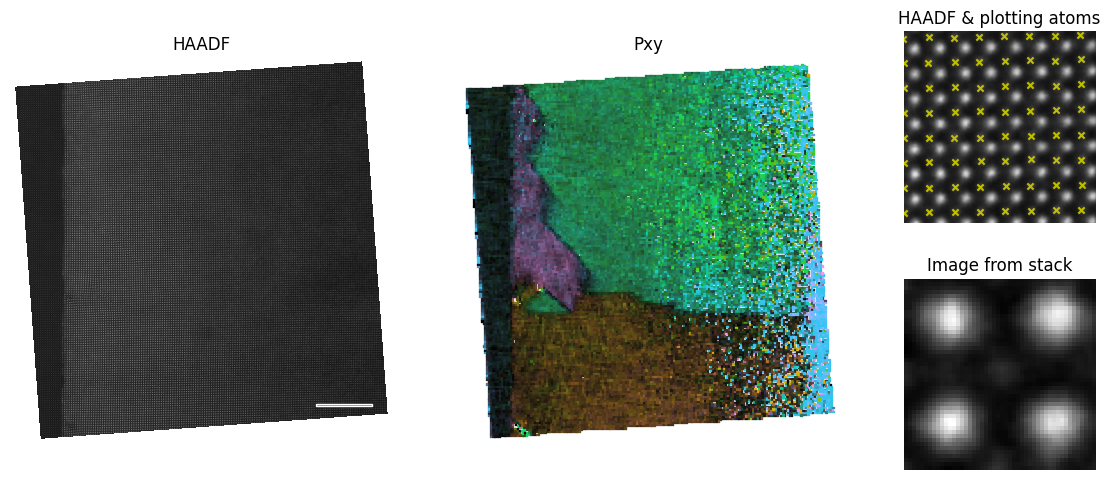

In [20]:
#selected parameter to plot: 'Pxy'
Pxybounds = np.nanpercentile(np.abs(np.hstack((ap['Pxy'][:,0],ap['Pxy'][:,1]))),95)

#Scalebar properties
sclbar = 10*10**-9
sclbarpos = [.8, .1]
sclbarwidth = 20

#Figure
fig = plt.figure(figsize=(14, 6), dpi=100)
gspec = plt.GridSpec(ncols=3, nrows=2, figure=fig, width_ratios = [2,2,1])

#HAADF Main Image
ax0 = fig.add_subplot(gspec[:,0])
ax0.imshow(imgdata,origin='bottom',cmap='gray')
#ax0.set_axis_off()
ax0.set_title('HAADF')
xl = ax0.get_xlim()
yl = ax0.get_ylim()
ax0.set_axis_off()
#scalebar
x = np.array((0,1,1,0))*sclbar/(imgscl[1]*imgunit[0]) + sclbarpos[0]*np.shape(imgdata)[1]
y = np.array((0,0,1,1))*sclbarwidth + sclbarpos[1]*np.shape(imgdata)[0]
xy = np.vstack((x, y)).T
sclbarrect = pch.Polygon(xy, edgecolor=[1,1,1], fill = True)
ax0.add_patch(sclbarrect)
print('scalebar is size: '+str(sclbar))

#Plot variable Pxy
ax1 = fig.add_subplot(gspec[:,1])
ax1.scatter(ap['xy'][subI,0], ap['xy'][subI,1], c=cP, s=1, marker='s')
ax1.set_xlim(xl)
ax1.set_ylim(yl)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_axis_off()
ax1.set_aspect(1)
ax1.set_title('Pxy')

#subindex of atoms used for plotting / image stack centers
ax3 = fig.add_subplot(gspec[0,2])
ax3.imshow(imgdata,origin='bottom',cmap='gray')
ax3.scatter(ap['xy'][subI,0],ap['xy'][subI,1],c='y',s=20,marker='x')
ax3.set_title('HAADF & plotting atoms')
ax3.set_xlim([2000,2200])
ax3.set_ylim([2000,2200])
ax3.set_axis_off()

#subindex of atoms used for plotting / image stack centers
ax4 = fig.add_subplot(gspec[1,2])
i=0
ax4.imshow(imp['imstack'][i,:,:],origin='bottom',cmap='gray')
ax4.set_title('Image from stack')
ax4.set_axis_off()

plt.show()
fig.savefig(mdirectory+'HAADFs.png')

L*a*b*/sRGB1 color [74.         43.32744987  0.07916144] / [1.00231165 0.58933091 0.71890533] 
-----> clipped to [ 7.39280225e+01  4.31251293e+01 -3.45887987e-02] / [1.         0.58933091 0.71890533]
L*a*b*/sRGB1 color [74.         39.48834041 11.61248657] / [1.00234225 0.59911648 0.63698712] 
-----> clipped to [73.92706751 39.27394343 11.49897974] / [1.         0.59911648 0.63698712]
L*a*b*/sRGB1 color [74.         35.77047749 23.1853857 ] / [1.00013692 0.60859702 0.5542359 ] 
-----> clipped to [73.99574623 35.75744179 23.17889669] / [1.         0.60859702 0.5542359 ]


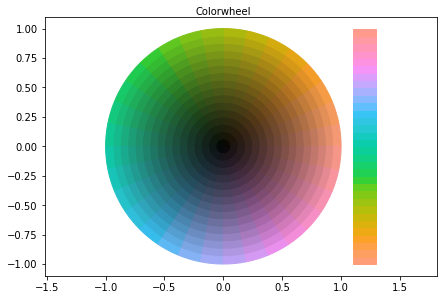

In [21]:
fig, ax = plt.subplots()
from papuc.analysis import plot_colorwheel,  UCS_cone_3D
plot_colorwheel(ax, my_map)
fig.tight_layout(pad= 0.1)
plt.savefig(mdirectory+'Colorwheel.png')
plt.show()

Image 1c: Dislocation

scalebar is size: 2e-09


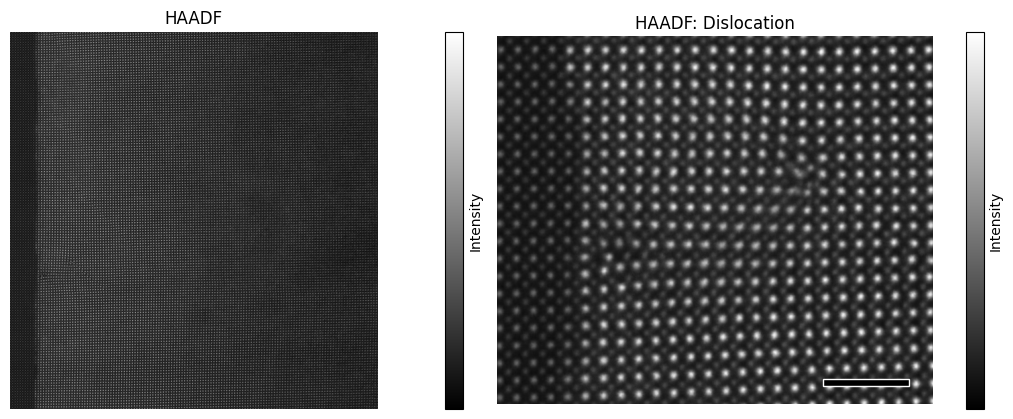

In [22]:
#image xy limits
main_subI = [350, 4000, 350, 4100]
disl_subI = [500, 1150, 1450, 2000]

#Scalebar properties
sclbar = 2*10**-9
sclbarpos = [.75, .05]
sclbarwidth = 10

#plotting value limits
adir_bounds = [-4, 4]

#Figure
fig = plt.figure(figsize=(13, 5), dpi=100)

ncol = 2
w_colorbar = .04
w_space = .15
widths = np.tile(np.array((1,w_colorbar)),ncol)
gspec = plt.GridSpec(ncols=ncol*2, nrows=1, figure=fig, width_ratios = widths, wspace=w_space)

#Full Image
ax0 = fig.add_subplot(gspec[0,0])
im0 = ax0.imshow(imgdata,origin='bottom',cmap='gray')
ax0.set_title('HAADF')
ax0.axis(main_subI)
ax0.set_axis_off()
ax0.set_label('')
#colorbar
ax0_l = fig.add_subplot(gspec[0,1])
plt.colorbar(im0,cax=ax0_l,label='Intensity',ticks=[])

#Dislocation
ax1 = fig.add_subplot(gspec[0,2])
im1 = ax1.imshow(imgdata, origin='bottom',cmap='gray')
ax1.set_title('HAADF: Dislocation')
ax1.axis(disl_subI)
ax1.set_axis_off()
#colorbar
ax1_l = fig.add_subplot(gspec[0,3])
plt.colorbar(im1,cax=ax1_l,label='Intensity',ticks=[])

#scalebar
x = np.array((0,1,1,0))*sclbar/(imgscl[1]*imgunit[0]) + sclbarpos[0]*(disl_subI[1]-disl_subI[0]) + disl_subI[0]
y = np.array((0,0,1,1))*sclbarwidth + sclbarpos[1]*(disl_subI[3]-disl_subI[2])+disl_subI[2]
xy = np.vstack((x, y)).T
sclbarrect = pch.Polygon(xy, edgecolor=[1,1,1], fill = True, facecolor=[0,0,0])
ax1.add_patch(sclbarrect)
print('scalebar is size: '+str(sclbar))

fig.savefig(mdirectory+'im1_Disl_Image.png')

rVAE

In [25]:
rvae = atomstat.rVAE(feature_arr, conv_encoder = True, training_cycles=100, batch_size=32, translation = True)
rvae.run()

Epoch: 1/100, Training loss: 21.3653, Test loss: 20.4602
Epoch: 2/100, Training loss: 20.4404, Test loss: 20.3636
Epoch: 3/100, Training loss: 20.2483, Test loss: 19.9131
Epoch: 4/100, Training loss: 19.5874, Test loss: 19.1600
Epoch: 5/100, Training loss: 18.7195, Test loss: 18.0708
Epoch: 6/100, Training loss: 17.7981, Test loss: 17.6418
Epoch: 7/100, Training loss: 16.9488, Test loss: 16.2656
Epoch: 8/100, Training loss: 16.2793, Test loss: 15.6847
Epoch: 10/100, Training loss: 15.6683, Test loss: 15.3926
Epoch: 11/100, Training loss: 15.4631, Test loss: 15.0772
Epoch: 12/100, Training loss: 15.2625, Test loss: 15.0388
Epoch: 13/100, Training loss: 15.1920, Test loss: 14.8873
Epoch: 14/100, Training loss: 15.0696, Test loss: 15.0550
Epoch: 15/100, Training loss: 14.9636, Test loss: 14.5917
Epoch: 16/100, Training loss: 14.8302, Test loss: 14.7742
Epoch: 17/100, Training loss: 14.7168, Test loss: 14.6071
Epoch: 18/100, Training loss: 14.6491, Test loss: 14.4310
Epoch: 19/100, Trainin

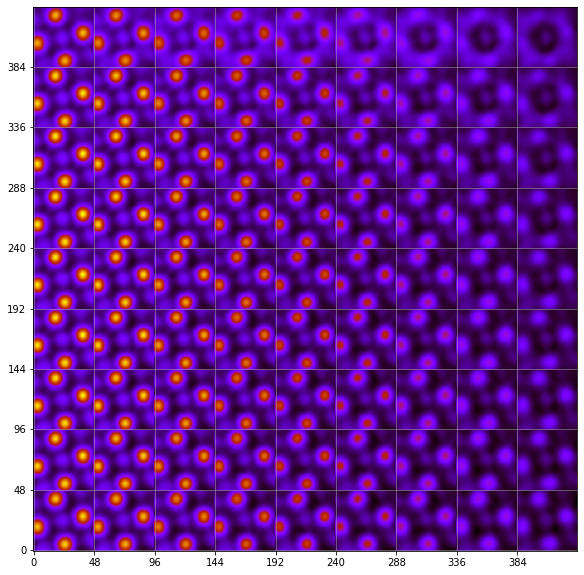

In [30]:
rvae.manifold2d(draw_grid = True, origin = 'lower')

In [31]:
z_mean, z_sd = rvae.encode(feature_arr)
z1, z2 , z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

**Latent Space Distributions**

User Supplied Offset - visually register rvae orientation w/ experimental Pxy

In [32]:
#a manual offset to register orientations of rvae to Pxy
ang_offset = np.deg2rad(-100)

Normalized Latent values (used for subsequent colorization)

In [33]:
l1 = z2[:,0]

#percentile
lrng = [1,99]
l1 = l1-np.percentile(l1,lrng[0])
l1 = (l1/np.percentile(l1,lrng[1]))
l2 = z2[:,1]
l2 = l2-np.percentile(l2,lrng[0])
l2 = (l2/np.percentile(l2,lrng[1]))

#min/max
"""
l1 = l1-np.min(l1)
l1 = (l1/np.max(l1))#/(2**.5)
l2 = z2[:,1]
l2 = l2-np.min(l2)
l2 = (l2/np.max(l2))#/(2**.5)
"""

'\nl1 = l1-np.min(l1)\nl1 = (l1/np.max(l1))#/(2**.5)\nl2 = z2[:,1]\nl2 = l2-np.min(l2)\nl2 = (l2/np.max(l2))#/(2**.5)\n'

In [34]:
#Pxy polar coords
Pmag = (np.sum(ap['Pxy'][subI,:]**2,axis=1))**.5 
Pdir = np.arctan2(ap['Pxy'][subI,1],ap['Pxy'][subI,0]).ravel()

Colorization

In [35]:
#Colormaps
my_map = papuc.example_maps.colormaps_CIELAB['perimeter1']  #vector colormap

#latent colors
ang = np.mod(z1+ang_offset,2*np.pi)
c1_ = my_map(ang, np.clip(l1,0,1))
c2_ = my_map(ang, np.clip(l2,0,1))
crvae = my_map(ang, np.ones_like(l1))
#Pxy colors
cP = my_map(Pdir,np.clip(Pmag/np.nanpercentile(Pmag,90),0,1))

papuc/papuc/core.py:28: RuntimeWarning: invalid value encountered in remainder
  values = splev( np.mod(theta-theta0 ,period) +theta0, tck)


KDE

In [36]:
def gkernel(ins,wincutoff=3):
  if np.size(ins)==1:
    ins = [ins,ins]
  gxv = np.arange(-np.ceil(ins[0])*wincutoff,np.ceil(ins[0])*wincutoff+1)
  gyv = np.arange(-np.ceil(ins[1])*wincutoff,np.ceil(ins[1])*wincutoff+1)
  gxx,gyy = np.meshgrid(gxv, gyv)
  z =  1/(2*np.pi*ins[0]*ins[1]) * np.exp(-.5*gxx**2/ins[0]**2 - .5*gyy**2/ins[1]**2)
  return z

def gkde(ix,iy,ival,s,ixx,iyy):
  #ix & iy is input xy positions
  #ival is the value at the datapoint
  #s = sigma for gausian kernel
  #ixx is x position meshgrid
  #iyy is y position meshgrid

  #get guassian kernel
  k = gkernel(s)

  xv = ixx[0,:]
  yv = iyy[:,0]

  #estimate each datapoint as sum of 4 at integer positions
  stpsz = xv[1]-xv[0]
  xpos = np.floor((ix-xv[0])/stpsz+1).astype('int')     #get first position
  xh = (ix-(xv[xpos-1]))/stpsz                          #fraction of xpos
  xl = 1-xh                                             #fraction of xpos+1
  stpsz = yv[1]-yv[0]
  ypos = np.floor((iy-yv[0])/stpsz+1).astype('int')
  yh = (iy-(yv[ypos-1]))/stpsz
  yl = 1-yh

  #density
  dens = np.zeros_like(ixx).astype('float')
  dens[ypos-1,xpos-1] = dens[ypos-1,xpos-1]   + xl*yl    #p00
  dens[ypos,xpos-1]   = dens[ypos,xpos-1]     + xl*yh    #p10
  dens[ypos-1,xpos]   = dens[ypos-1,xpos]     + xh*yl    #p01
  dens[ypos,xpos]     = dens[ypos,xpos]       + xh*yh    #p11

  #convolve w/ kernel
  densitymap = signal.convolve2d(dens,k,mode='same')

  return densitymap

In [37]:
#kernel density estimate maps

#L1 vs L2
xystep = .05

#bounds
xmin_l1l2 = np.min(z2[:,0])-1*xystep
xmax_l1l2 = np.max(z2[:,0])+1*xystep
ymin_l1l2 = np.min(z2[:,1])-1*xystep
ymax_l1l2 = np.max(z2[:,1])+1*xystep
xx_l1l2,yy_l1l2 = np.meshgrid(np.arange(xmin_l1l2,xmax_l1l2,xystep),np.arange(ymin_l1l2,ymax_l1l2,xystep))

s=6     #gaussian kernel sigma

dmap_l1l2 = gkde(z2[:,0],z2[:,1],np.ones_like(z2[:,0]),s,xx_l1l2,yy_l1l2)


#angle vs L1
#bounds
astep = 2
xmin_al1 = np.min(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)))-1*astep
xmax_al1 = np.max(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)))+1*astep
ymin_al1 = np.min(z2[:,0])-1*xystep
ymax_al1 = np.max(z2[:,0])+1*xystep
xx_al1,yy_al1 = np.meshgrid(np.arange(xmin_al1,xmax_al1,astep),np.arange(ymin_al1,ymax_al1,xystep))

s=6     #gaussian kernel sigma

dmap_angl1 = gkde(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)),z2[:,0],np.ones_like(z2[:,0]),s,xx_al1,yy_al1)

#angle vs L2
#bounds
astep = 2
xmin_al2 = np.min(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)))-1*astep
xmax_al2 = np.max(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)))+1*astep
ymin_al2 = np.min(z2[:,1])-1*xystep
ymax_al2 = np.max(z2[:,1])+1*xystep
xx_al2,yy_al2 = np.meshgrid(np.arange(xmin_al2,xmax_al2,astep),np.arange(ymin_al2,ymax_al2,xystep))

s=6     #gaussian kernel sigma

dmap_angl2 = gkde(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)),z2[:,1],np.ones_like(z2[:,1]),s,xx_al2,yy_al2)

Display

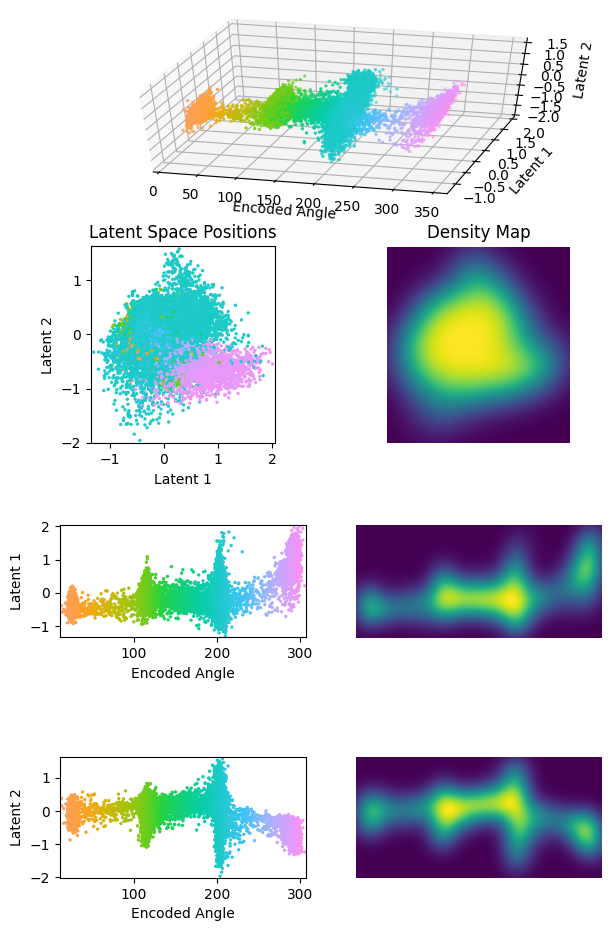

In [38]:
fig = plt.figure(figsize=(7, 12), dpi=100)

gspec = plt.GridSpec(ncols=2, nrows=4, figure=fig, width_ratios = [1,1], hspace=.2)

#HAADF Main Image
ax0 = fig.add_subplot(gspec[0,:], projection='3d')
ax1 = fig.add_subplot(gspec[1,0])
ax2 = fig.add_subplot(gspec[1,1])
ax3 = fig.add_subplot(gspec[2,0])
ax4 = fig.add_subplot(gspec[2,1])
ax5 = fig.add_subplot(gspec[3,0])
ax6 = fig.add_subplot(gspec[3,1])

ax0.scatter(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)),z2[:,0],z2[:,1],c=crvae,s=2)
ax0.view_init(elev=45, azim=-75)
ax0.set_xlabel('Encoded Angle')
#ax0.set_xlim([np.min(np.rad2deg(np.mod(z1+ang_offset,2*np.pi))),np.max(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)))])
ax0.set_xlim([0,360])
ax0.set_zlim([ymin_l1l2,ymax_l1l2])
ax0.set_zlabel('Latent 2')
ax0.set_ylim([xmin_l1l2,xmax_l1l2])
ax0.set_ylabel('Latent 1')
temp = ax0.get_xlim
#ax0.set_xticks([0,360])
#ax0.set_yticks([xmin_l1l2,0,xmax_l1l2])
#ax0.set_zticks([ymin_l1l2,0,ymax_l1l2])

#L1vsL2
ax1.scatter(z2[:,0],z2[:,1],s=2,c=crvae)
ax1.set_title('Latent Space Positions')
ax1.set_xlim([xmin_l1l2,xmax_l1l2])
ax1.set_xlabel('Latent 1')
ax1.set_ylim([ymin_l1l2,ymax_l1l2])
ax1.set_ylabel('Latent 2')
ax1.set_aspect(xystep/xystep)
ax2.imshow(dmap_l1l2,origin='bottom')
ax2.set_title('Density Map')
ax2.set_xticks([0,np.shape(xx_l1l2)[1]])
ax2.set_xticklabels(['%.2f' % xmin_l1l2, '%.2f' % xmax_l1l2])
ax2.set_xlabel('Latent 1')
ax2.set_yticks([0,np.shape(xx_l1l2)[0]])
ax2.set_yticklabels(['%.2f' % ymin_l1l2, '%.2f' % ymax_l1l2])
ax2.set_ylabel('Latent 2')
ax2.set_axis_off()

#angvsl1
ax3.scatter(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)),z2[:,0],s=2,c=crvae)
#ax3.set_title('Latent Space Positions')
ax3.set_xlim([xmin_al1,xmax_al1])
ax3.set_xlabel('Encoded Angle')
ax3.set_ylim([ymin_al1,ymax_al1])
ax3.set_ylabel('Latent 1')
ax3.set_aspect(astep/xystep)

ax4.imshow(dmap_angl1,origin='bottom')
#ax4.set_title('Density Map')
ax4.set_xticks([0,np.shape(xx_al1)[1]])
ax4.set_xticklabels(['%.2f' % xmin_al1, '%.2f' % xmax_al1])
ax4.set_xlabel('Encoded Angle')
ax4.set_yticks([0,np.shape(xx_al1)[0]])
ax4.set_yticklabels(['%.2f' % ymin_al1, '%.2f' % ymax_al1])
ax4.set_ylabel('Latent 1')
ax4.set_axis_off()

#angvsl1
ax5.scatter(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)),z2[:,1],s=2,c=crvae)
#ax5.set_title('Latent Space Positions')
ax5.set_xlim([xmin_al2,xmax_al2])
ax5.set_xlabel('Encoded Angle')
ax5.set_ylim([ymin_al2,ymax_al2])
ax5.set_ylabel('Latent 2')
ax5.set_aspect(astep/xystep)

ax6.imshow(dmap_angl2,origin='bottom')
#ax6.set_title('Density Map')
ax6.set_xticks([0,np.shape(xx_al2)[1]])
ax6.set_xticklabels(['%.2f' % xmin_al2, '%.2f' % xmax_al2])
ax6.set_xlabel('Encoded Angle')
ax6.set_yticks([0,np.shape(xx_al2)[0]])
ax6.set_yticklabels(['%.2f' % ymin_al2, '%.2f' % ymax_al2])
ax6.set_ylabel('Latent 2')
ax6.set_axis_off()

# fig.savefig(mdirectory+'Latent Distribution.png')

Histograms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in remainder
  """


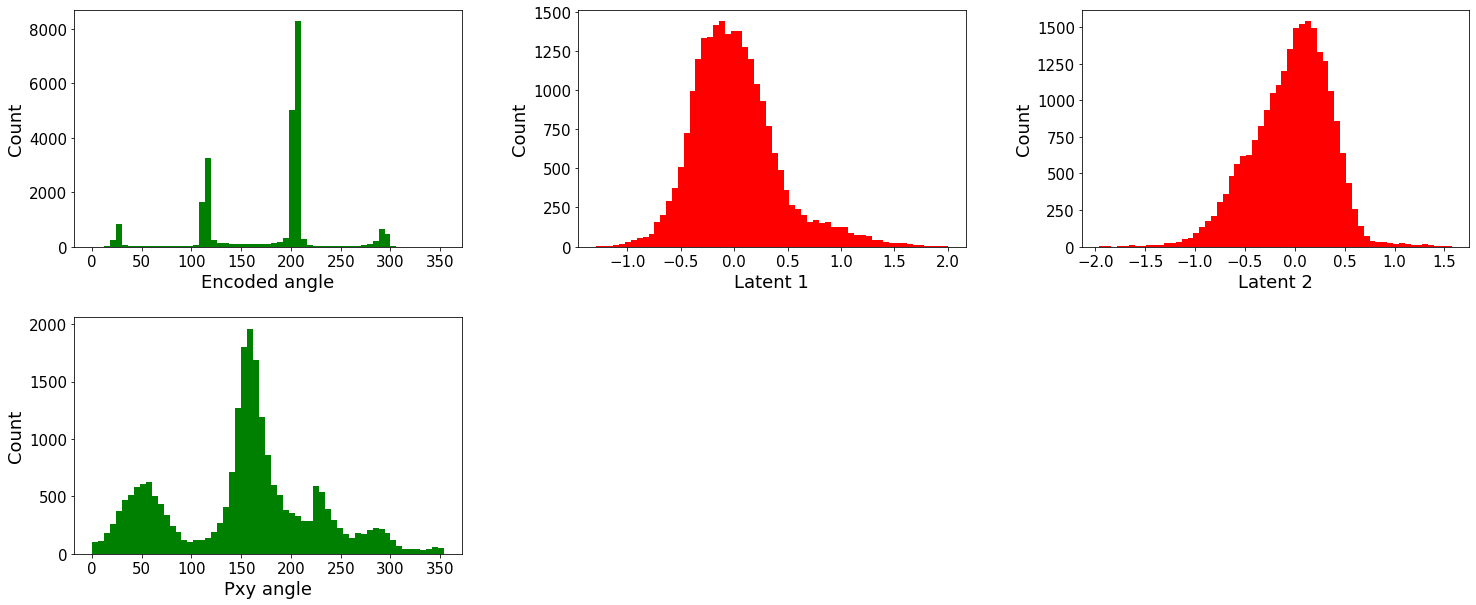

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
#angles
ax[0,0].hist(np.rad2deg(np.mod(z1+ang_offset,2*np.pi)), bins=np.arange(0,360,6), color='g')

ax[1,0].hist(np.rad2deg(np.mod(Pdir,2*np.pi)), bins=np.arange(0,360,6), color='g')

#ax[0,0].hist(np.mod(z1,2*np.pi), bins=60, color='green', range=((0,2*np.pi)))
ax[0,1].hist(z2[:, 0], bins=60, color='red')
ax[0,2].hist(z2[:, 1], bins=60, color='red')
ax[0,0].set_xlabel("Encoded angle", fontsize=18)
ax[1,0].set_xlabel("Pxy angle", fontsize=18)
ax[0,1].set_xlabel("Latent 1", fontsize=18) #X-offset for rVAE, L1 for rrVAE
ax[0,2].set_xlabel("Latent 2", fontsize=18) #Y-offset for rVAE, L2 for rrVAE

#
ax[1,1].set_axis_off()
ax[1,2].set_axis_off()

for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3,hspace=0.3)

fig.savefig(mdirectory+'Latent Histograms.png')

Real Space Distributions (latent vars)

Text(0.5, 1.0, 'angle-colorized Latent 2')

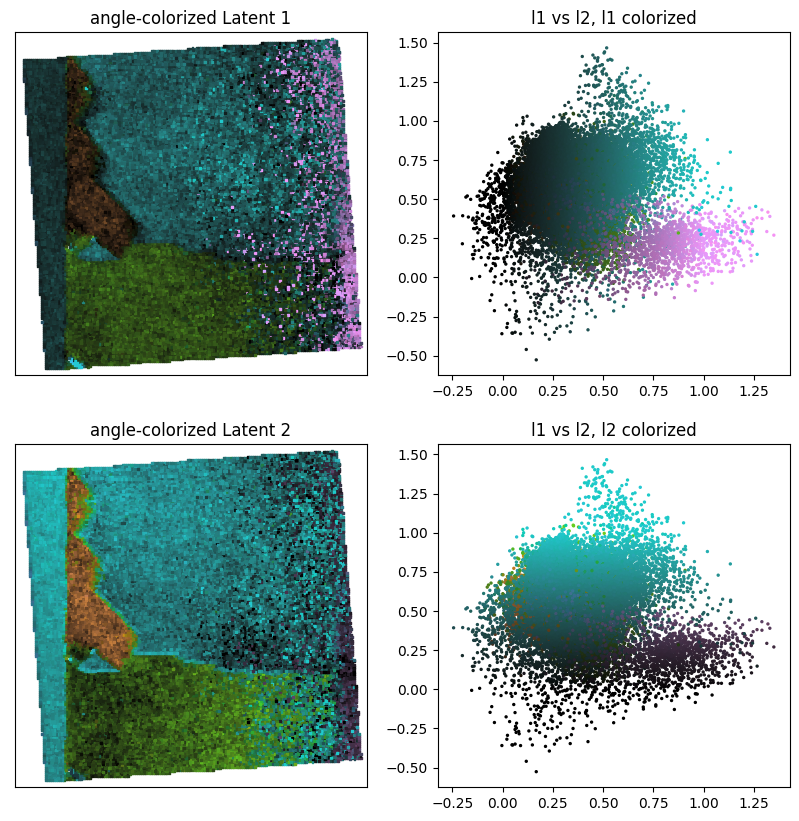

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi=100)
ax[0,1].scatter(l1,l2,s=2,c=c1_)
ax[0,1].set_title('l1 vs l2, l1 colorized')
ax[1,1].scatter(l1,l2,s=2,c=c2_)
ax[1,1].set_title('l1 vs l2, l2 colorized')
ax[0,0].scatter(ap['xy'][subI,0], ap['xy'][subI,1], c=c1_, s=2, marker='s')
ax[0,0].set_xlim(xl)
ax[0,0].set_ylim(yl)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('angle-colorized Latent 1')
ax[1,0].scatter(ap['xy'][subI,0], ap['xy'][subI,1], c=c2_, s=2, marker='s')
ax[1,0].set_xlim(xl)
ax[1,0].set_ylim(yl)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title('angle-colorized Latent 2')

fig.savefig(mdirectory+'Latent Realspace.png')

Clustering (Sergei's Gaussian Mixture code did a good job labeling the peaks)

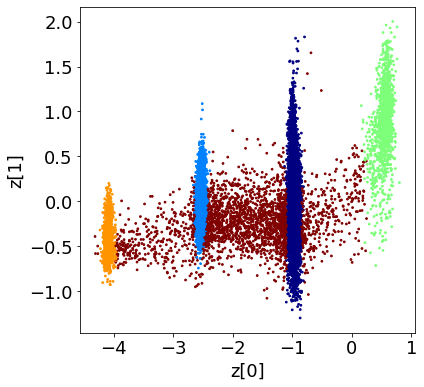

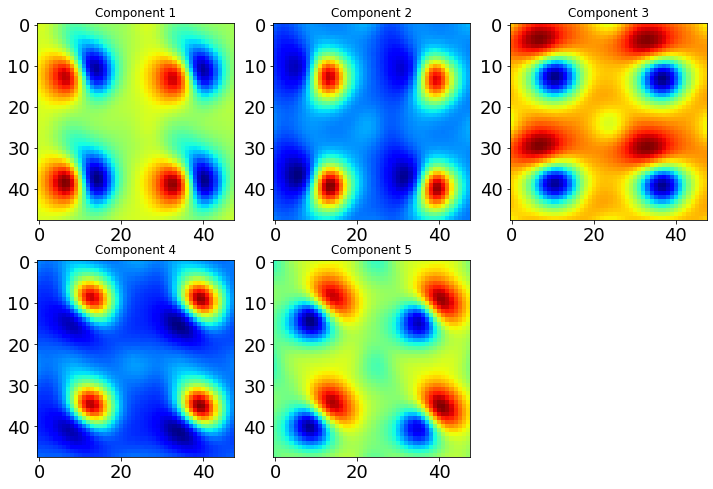

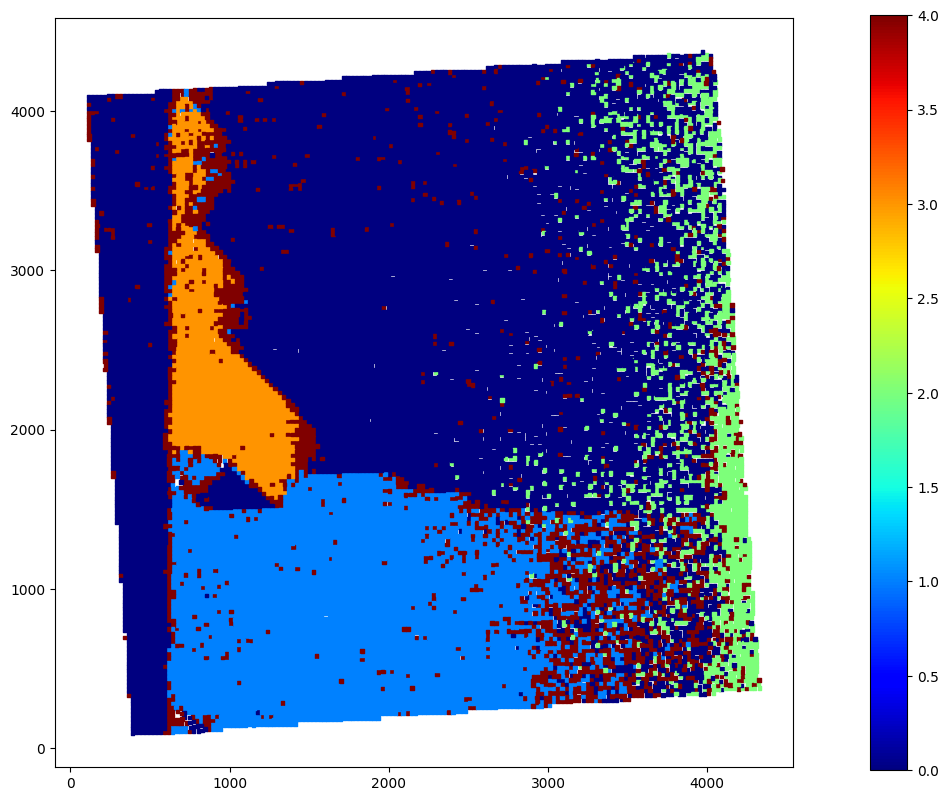

In [41]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

#z = z3

nc = 5

x = z1
y = z2[:,0]
z = z2[:,1]

z_comb = np.stack((x, y,z)).T # Choose the combination of variables to cluster on
im_cg = feature_arr.mean(axis = 0)

gmmp = GaussianMixture(n_components=nc, covariance_type='full') #diag
gmm_zp = gmmp.fit_predict(z_comb)

fig1 = plt.figure(figsize=(6,6))
plt.scatter(z_comb[:, 0], z_comb[:,1], c=gmm_zp, cmap="jet", s = 3)
plt.xlabel("z[0]", fontsize = 18)
plt.ylabel("z[1]", fontsize = 18)
plt.tick_params(labelsize = 18)

rows = int(np.ceil(float(nc)/4))
colms = int(np.ceil(float(nc)/rows))

gs2 = plt.GridSpec(rows, colms)
fig2 = plt.figure(figsize = (4*colms, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(feature_arr[gmm_zp == i, :].mean(axis = 0).reshape(48,48) - im_cg, cmap = 'jet')
    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)

gs3 = plt.GridSpec(1, 2, width_ratios=[1,.05])
fig3 = plt.figure(figsize=(11, 10), dpi=100)
ax0 = fig3.add_subplot(gs3[0])
ax1 = fig3.add_subplot(gs3[1])
s1 = ax0.scatter(ap['xy'][subI,0], ap['xy'][subI,1], c=gmm_zp, cmap = "jet", s = 6, marker='s')
ax0.set_aspect(1)
plt.colorbar(s1,cax=ax1)
plt.show()

fig1.savefig(mdirectory+'Lspace clusters.png')
fig2.savefig(mdirectory+'Lspace cluster decoded.png')
fig3.savefig(mdirectory+'Rspace labels.png')